In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from matplotlib import pyplot

In [17]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])


In [18]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [19]:
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_2016-2020.csv"
filename_ibex ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_ibex_2018-2020.csv"
filename_ibex_prices ="../data/ibex_historico.csv"
filename_precios_bolsa = "../data/es_mse_mean_day.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_ibex = pd.read_csv(filename_ibex, sep=";")
df_ibex_prices = pd.read_csv(filename_ibex_prices, sep=",")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
df_total = pd.merge(left=df_x, right=df_ibex_prices, left_on='normalised_date', right_on='Date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_ibex", "Close"]]

df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones.diff()
df_total.sentiment_ibex = df_total.sentiment_ibex.diff()
df_total.Close = df_total.Close.diff()
df_total = df_total.dropna()
df_total = df_total.rename(columns={"Close": "ibex_change", "price_change": "madrid_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float)
df_total['sentiment_ibex'] = df_total['sentiment_ibex'].astype(float)
df_total['ibex_change'] = df_total['ibex_change'].astype(float)
df_total['madrid_change'] = df_total['madrid_change'].astype(float)

df_total = df_total[:-100]

df_total


,normalised_date,sentiment_asociacones,sentiment_ibex,ibex_change,date,madrid_change
1,2017-01-24,0.031742,-0.000420,82.400390,2017-01-24,1.260981
2,2017-01-25,-0.007774,-0.432036,162.099610,2017-01-25,1.614972
3,2017-01-26,-0.038962,0.479446,-36.500000,2017-01-26,-0.810021
4,2017-01-27,0.046862,-0.417707,-8.700196,2017-01-27,-0.140292
5,2017-01-30,-0.008826,0.478613,-142.799804,2017-01-30,-1.385265
...,...,...,...,...,...,...
741,2019-12-17,-0.021648,-0.018915,-64.699218,2019-12-17,-0.553620
742,2019-12-18,0.049066,0.003646,5.899414,2019-12-18,-0.258039
743,2019-12-19,-0.009887,-0.003893,-4.599610,2019-12-19,-0.007002
744,2019-12-20,0.090181,0.017316,58.299805,2019-12-20,0.090962


In [20]:

num_steps = 15
future_steps = 1
X_sent_asoc = df_total["sentiment_asociacones"].values[:-future_steps]
X_sent_ibex = df_total["sentiment_ibex"].values[:-future_steps]
X_ibex_prices = df_total["ibex_change"].values[:-future_steps]
X_madrid_prices = df_total["madrid_change"].values[:-future_steps]
X_madrid_prices_next = df_total["madrid_change"].values

X = np.array(create_window_data_arrays((X_sent_asoc, X_sent_ibex, X_ibex_prices,X_madrid_prices), num_steps))
#X = np.array(create_window_data_arrays((X_sent_asoc, X_sent_ibex), num_steps))
Y = create_window_data_array_with_shift(X_madrid_prices_next,future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(729, 15, 4) (729, 1)


In [21]:
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.1, shuffle=False)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(656, 15, 4) (656, 1) (73, 15, 4) (73, 1)


Epoch 1/250
17/17 - 0s - loss: 4.5683 - accuracy: 0.0000e+00 - val_loss: 1.2346 - val_accuracy: 0.0000e+00
Epoch 2/250
17/17 - 0s - loss: 2.2691 - accuracy: 0.0000e+00 - val_loss: 0.8739 - val_accuracy: 0.0000e+00
Epoch 3/250
17/17 - 0s - loss: 1.6121 - accuracy: 0.0000e+00 - val_loss: 0.8099 - val_accuracy: 0.0000e+00
Epoch 4/250
17/17 - 0s - loss: 1.3101 - accuracy: 0.0000e+00 - val_loss: 0.7014 - val_accuracy: 0.0000e+00
Epoch 5/250
17/17 - 0s - loss: 1.1308 - accuracy: 0.0000e+00 - val_loss: 0.6649 - val_accuracy: 0.0000e+00
Epoch 6/250
17/17 - 0s - loss: 0.9558 - accuracy: 0.0000e+00 - val_loss: 0.6495 - val_accuracy: 0.0000e+00
Epoch 7/250
17/17 - 0s - loss: 0.8918 - accuracy: 0.0000e+00 - val_loss: 0.6239 - val_accuracy: 0.0000e+00
Epoch 8/250
17/17 - 0s - loss: 0.8449 - accuracy: 0.0000e+00 - val_loss: 0.6117 - val_accuracy: 0.0000e+00
Epoch 9/250
17/17 - 0s - loss: 0.8245 - accuracy: 0.0000e+00 - val_loss: 0.6032 - val_accuracy: 0.0000e+00
Epoch 10/250
17/17 - 0s - loss: 0.794

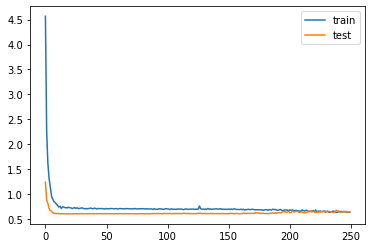

In [22]:
output_size = future_steps
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.7))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/100
17/17 - 0s - loss: 6.6168 - accuracy: 0.0000e+00 - mae: 6.6168 - val_loss: 1.1552 - val_accuracy: 0.0000e+00 - val_mae: 1.1552
Epoch 2/100
17/17 - 0s - loss: 1.7267 - accuracy: 0.0000e+00 - mae: 1.7267 - val_loss: 0.6518 - val_accuracy: 0.0000e+00 - val_mae: 0.6518
Epoch 3/100
17/17 - 0s - loss: 0.8176 - accuracy: 0.0000e+00 - mae: 0.8176 - val_loss: 0.6242 - val_accuracy: 0.0000e+00 - val_mae: 0.6242
Epoch 4/100
17/17 - 0s - loss: 0.7304 - accuracy: 0.0000e+00 - mae: 0.7304 - val_loss: 0.6190 - val_accuracy: 0.0000e+00 - val_mae: 0.6190
Epoch 5/100
17/17 - 0s - loss: 0.7034 - accuracy: 0.0000e+00 - mae: 0.7034 - val_loss: 0.6076 - val_accuracy: 0.0000e+00 - val_mae: 0.6076
Epoch 6/100
17/17 - 0s - loss: 0.6980 - accuracy: 0.0000e+00 - mae: 0.6980 - val_loss: 0.6097 - val_accuracy: 0.0000e+00 - val_mae: 0.6097
Epoch 7/100
17/17 - 0s - loss: 0.6967 - accuracy: 0.0000e+00 - mae: 0.6967 - val_loss: 0.6168 - val_accuracy: 0.0000e+00 - val_mae: 0.6168
Epoch 8/100
17/17 - 0s - lo

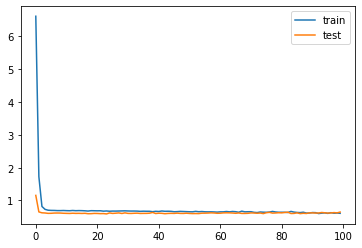

In [26]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.7))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

2/2 [==============================] - 0s 887us/step
0.6465924432027015
[[ 8.17110222e-01 -7.54708843e-03]
 [ 7.78123932e-01  5.53175062e-02]
 [-1.51659280e+00 -1.14916556e-03]
 [ 1.56726091e-02  1.07167453e-01]
 [ 2.37036356e-01 -3.54895234e-01]
 [ 9.81716730e-01 -1.05417043e-01]
 [ 1.41691892e-01  8.70016292e-02]
 [-1.24991572e+00  6.50839284e-02]
 [ 4.74965562e-01 -1.12074755e-01]
 [-1.03694218e+00 -1.14916556e-03]
 [ 2.74535272e-01 -3.54861289e-01]
 [ 7.30343929e-01  3.27260159e-02]
 [ 2.94466056e-01  2.11028308e-01]
 [-5.60131152e-01  7.14245252e-04]
 [-2.56899406e+00 -6.74388766e-01]
 [ 7.72556855e-02 -4.35129702e-01]
 [ 6.73011065e-01 -1.84050739e-01]
 [ 8.47009896e-01  1.97298691e-01]
 [-1.32753686e+00  4.50585112e-02]
 [ 6.98783723e-01 -4.42232122e-04]
 [ 1.59029434e+00 -1.24879420e-01]
 [ 2.14353386e+00 -3.65563892e-02]
 [-5.13868912e-01 -1.14916556e-03]
 [ 1.14559500e+00  1.27197519e-01]
 [ 8.67808424e-01 -1.14916556e-03]
 [-1.25999514

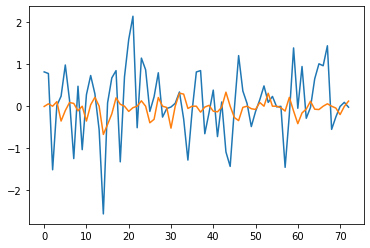

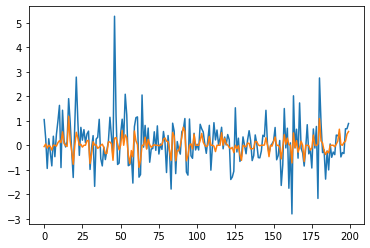

In [27]:
#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)


print("---")
#print(M_untransformed)

#print(df_total.values[-3:])


def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = model.predict(X, batch_size=40, verbose=1)
print("----")
print(mean_absolute_error(Y, y_pred))
print("----")

print(mean_absolute_percentage_error(y_pred,Y))


y_pred_test = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred_test))
print(r2_score(y_pred_test,test_y))
print(mean_absolute_percentage_error(test_y,y_pred_test))

M = np.column_stack((test_y, y_pred_test))
plot1 = plt.figure(2)
plt.plot(M)

y_pred_train = model.predict(train_X, batch_size=40, verbose=1)
print(mean_absolute_error(train_y, y_pred_train))
print(r2_score(y_pred_train,train_y))
print(mean_absolute_percentage_error(train_y,y_pred_train))

M = np.column_stack((Y, y_pred))

plot1 = plt.figure(3)
plt.plot(M[:200])

plt.show()


In [10]:
def take_predecesor(y):
    y_pred = y[:-1]
    y_pred = np.insert(y_pred, 0, 0, axis=0)
    return y_pred

Y_null_model = take_predecesor(Y)

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.        ]
 [-1.56814621  0.58604795]
 [-0.7183444  -1.56814621]
 [-0.05927397 -0.7183444 ]
 [ 0.75498299 -0.05927397]
 [-0.92035478  0.75498299]
 [ 0.73546661 -0.92035478]
 [ 0.08049359  0.73546661]
 [ 1.04769402  0.08049359]
 [ 0.27684574  1.04769402]]
1.1543982682410578
-1.0332154827669124
inf


In [11]:
predecesor_1 = take_predecesor(Y)
predecesor_2 = take_predecesor(predecesor_1)

Y_null_model = (predecesor_1 + predecesor_2)/2

M=np.column_stack((Y, Y_null_model))
print(M[:10])
print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.        ]
 [-1.56814621  0.29302398]
 [-0.7183444  -0.49104913]
 [-0.05927397 -1.14324531]
 [ 0.75498299 -0.38880918]
 [-0.92035478  0.34785451]
 [ 0.73546661 -0.08268589]
 [ 0.08049359 -0.09244408]
 [ 1.04769402  0.4079801 ]
 [ 0.27684574  0.56409381]]
0.9818592538167107
-1.7468596427928431
inf


In [12]:
mean = np.mean(Y)
Y_null_model = np.full(Y.shape, mean)
np.column_stack((Y, Y_null_model))

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795 -0.03544755]
 [-1.56814621 -0.03544755]
 [-0.7183444  -0.03544755]
 [-0.05927397 -0.03544755]
 [ 0.75498299 -0.03544755]
 [-0.92035478 -0.03544755]
 [ 0.73546661 -0.03544755]
 [ 0.08049359 -0.03544755]
 [ 1.04769402 -0.03544755]
 [ 0.27684574 -0.03544755]]
0.8188123962996046
-3.300079309257901e+34
2309.926728590984
